## **Câu 3: Regression - Combined Cycle Power Plant (1.0 điểm)**
Use CCPP dataset to build the model to predict the net hourly electrical energy output 
(EP) of the plant based on Features consist of hourly average ambient variables 
Temperature (T), Ambient Pressure (AP), Relative Humidity (RH) and Exhaust Vacuum 
(V)

Read more information here:
http://archive.ics.uci.edu/ml/datasets/Combined+Cycle+Power+Plant


### **Data Set Information**:

The dataset contains 9568 data points collected from a Combined Cycle Power Plant over 6 years (2006-2011), when the power plant was set to work with full load. Features consist of hourly average ambient variables Temperature (T), Ambient Pressure (AP), Relative Humidity (RH) and Exhaust Vacuum (V) to predict the net hourly electrical energy output (EP) of the plant.
A combined cycle power plant (CCPP) is composed of gas turbines (GT), steam turbines (ST) and heat recovery steam generators. In a CCPP, the electricity is generated by gas and steam turbines, which are combined in one cycle, and is transferred from one turbine to another. While the Vacuum is colected from and has effect on the Steam Turbine, he other three of the ambient variables effect the GT performance.
For comparability with our baseline studies, and to allow 5x2 fold statistical tests be carried out, we provide the data shuffled five times. For each shuffling 2-fold CV is carried out and the resulting 10 measurements are used for statistical testing.
We provide the data both in .ods and in .xlsx formats.

### **Attribute Information:**

Features consist of hourly average ambient variables
- Temperature (T) in the range 1.81°C and 37.11°C,
- Ambient Pressure (AP) in the range 992.89-1033.30 milibar,
- Relative Humidity (RH) in the range 25.56% to 100.16%
- Exhaust Vacuum (V) in teh range 25.36-81.56 cm Hg
- Net hourly electrical energy output (EP) 420.26-495.76 MW
The averages are taken from various sensors located around the plant that record the ambient variables every second. The variables are given without normalization.

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.3/spark-3.1.3-bin-hadoop3.2.tgz
!tar xf spark-3.1.3-bin-hadoop3.2.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.3-bin-hadoop3.2"

In [ ]:
import findspark
findspark.init()

In [ ]:
import pyspark
from pyspark import SparkContext
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession

from pyspark.sql import functions as F
from pyspark.sql.functions import *
from pyspark.sql.types import *

from pyspark.ml.feature import Tokenizer,StopWordsRemover
from pyspark.ml.feature import CountVectorizer,IDF,StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vector

from scipy import stats
#from datetime import datetime
import datetime

from pyspark.sql.functions import mean, stddev, col, log
from pyspark.sql.functions import to_date, dayofweek, to_timestamp
from pyspark.sql import types 
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DateType
from pyspark.sql.functions import year, month
from pyspark.sql.functions import dayofmonth, weekofyear
from pyspark.sql.functions import split, explode
from pyspark.sql.functions import coalesce, first, lit
from pyspark.ml.feature import Binarizer, OneHotEncoder, Bucketizer, VectorAssembler, StringIndexer
from pyspark.sql.functions import round
from pyspark.sql.window import Window
from functools import reduce

from pyspark.sql.functions import regexp_extract, col
from pyspark.sql.functions import datediff
from pyspark.sql.functions import when
from pyspark.sql import DataFrame

from pyspark.ml.linalg import Vectors


In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor, GBTRegressionModel, GBTRegressor, AFTSurvivalRegression, IsotonicRegression
from pyspark.ml.evaluation import RegressionEvaluator

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import datetime
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from scipy.stats import chi2_contingency
from scipy.stats import chi2
from scipy.stats import iqr
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
from scipy.stats import iqr
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
%cd '/content/gdrive/My Drive/LDS9_K273_ONLINE_Đinh Viết Trung/LDS9_K273_DinhVietTrung_Cuoi_ky'

Mounted at /content/gdrive
/content/gdrive/My Drive/LDS9_K273_ONLINE_Đinh Viết Trung/LDS9_K273_DinhVietTrung_Cuoi_ky


In [ ]:
from pyspark import SparkContext
sc = SparkContext()


In [ ]:
spark = SparkSession(sc)

In [ ]:
# có 5 sheets, nhiều quá, huhu
xls = pd.ExcelFile('data/CCPP/Folds5x2_pp.xlsx')
df_sheet1 = spark.createDataFrame(pd.read_excel(xls, 'Sheet1'))
df_sheet2 = spark.createDataFrame(pd.read_excel(xls, 'Sheet2'))
df_sheet3 = spark.createDataFrame(pd.read_excel(xls, 'Sheet3'))
df_sheet4 = spark.createDataFrame(pd.read_excel(xls, 'Sheet4'))
df_sheet5 = spark.createDataFrame(pd.read_excel(xls, 'Sheet5'))


In [ ]:
dfs = [df_sheet1, df_sheet2, df_sheet3, df_sheet4, df_sheet5]
df = reduce(DataFrame.unionAll, dfs)

## **Phân tích khai phá dữ liệu và tiền xử lý (EDA & Preprocessing)**

In [ ]:
df.show(5)

+-----+-----+-------+-----+------+
|   AT|    V|     AP|   RH|    PE|
+-----+-----+-------+-----+------+
|14.96|41.76|1024.07|73.17|463.26|
|25.18|62.96|1020.04|59.08|444.37|
| 5.11| 39.4|1012.16|92.14|488.56|
|20.86|57.32|1010.24|76.64|446.48|
|10.82| 37.5|1009.23|96.62| 473.9|
+-----+-----+-------+-----+------+
only showing top 5 rows



In [ ]:
df.count()

47840

In [ ]:
df.printSchema()

root
 |-- AT: double (nullable = true)
 |-- V: double (nullable = true)
 |-- AP: double (nullable = true)
 |-- RH: double (nullable = true)
 |-- PE: double (nullable = true)



In [ ]:
df.describe().show()

+-------+------------------+------------------+-----------------+------------------+-----------------+
|summary|                AT|                 V|               AP|                RH|               PE|
+-------+------------------+------------------+-----------------+------------------+-----------------+
|  count|             47840|             47840|            47840|             47840|            47840|
|   mean|19.651231187290975| 54.30580372073589|1013.259078177256| 73.30897784280937| 454.365009406355|
| stddev| 7.452161658340004|12.707361709685818|5.938535418520817|14.599658352081471|17.06628146683768|
|    min|              1.81|             25.36|           992.89|             25.56|           420.26|
|    max|             37.11|             81.56|           1033.3|            100.16|           495.76|
+-------+------------------+------------------+-----------------+------------------+-----------------+



In [ ]:
df.columns

['AT', 'V', 'AP', 'RH', 'PE']

'''
các cột của data đều là kiểu số 
Vì tên các column là 'AT', 'V', 'AP', 'RH', 'PE'
tương ứng 'Average_Temperature', 'Exhaust_Vacuum', 'Ambient_Pressure', 'Relative_Humidity', 'Net_Hourly_Electrical_Energy_Output'

'''

### **Clean Data**

**Check Missing Data**

In [ ]:
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas().T

,0
AT,0
V,0
AP,0
RH,0
PE,0


In [ ]:
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()

+---+---+---+---+---+
| AT|  V| AP| RH| PE|
+---+---+---+---+---+
|  0|  0|  0|  0|  0|
+---+---+---+---+---+



In [ ]:
'''
ko có null, ko có nan, mừng quá
'''

'\nko có null, ko có nan, mừng quá\n'

### **Check duplicates**

In [ ]:
total = df.count()
distinct = df.distinct().count()

print('df có', total, 'records')
print('df có', distinct, 'distinct records')

print(('df có các duplicate records với', total - distinct, 'duplicate records') if total > distinct else 'df không có các duplicate records')

df có 47840 records
df có 9527 distinct records
('df có các duplicate records với', 38313, 'duplicate records')


In [ ]:
total = df.count()
distinct = df.distinct().count()

print('df', 'có', total, 'records')
print('df', 'có', distinct, 'distinct records')
if total > distinct:
    print('df', 'có các duplicate records với ' + str(total - distinct) + ' duplicate records')
else:
    print('df', 'ko có duplicate records')

df có 47840 records
df có 9527 distinct records
df có các duplicate records với 38313 duplicate records


In [ ]:
df = df.drop_duplicates()
df.count()

9527

## **Xác định requirement**
- predictor (input): <> price: các thuộc tính khác PE
- target: PE 

data type: numeric

In [ ]:
df_pd = df.toPandas()

In [ ]:
numbers = [i for i in df_pd.columns if df_pd.dtypes[i] != "object"]
objects = [i for i in df_pd.columns if df_pd.dtypes[i] == "object"]

In [ ]:
### xét các biến có dtype là object
i = 0
for obj in objects:
    print(i, "/", obj, "\t len=", len(df_pd[obj].unique()), ":", df_pd[obj].unique())
    i = i + 1

In [ ]:
### xét các biến có dtype != object
i = 0
for obj in numbers:
    print(
        i,
        "/",
        obj,
        "\t len =",
        len(df_pd[obj].unique()),
        df_pd[obj].unique() if len(df_pd[obj].unique()) < 20 else "",
    )
    i = i + 1

0 / AT 	 len = 2773 
1 / V 	 len = 634 
2 / AP 	 len = 2517 
3 / RH 	 len = 4546 
4 / PE 	 len = 4836 


'''
Từ mô tả dataset của đề bài và từ kết quả trên, 
ta nhận thấy tất cả các thuộc tính của dataset (AT, V, AP, RH, PE) đều là biến liên tục (continuous variable)
'''

### **Phân tích đơn biến**

In [ ]:
def continuous_univariate_analysis(f):
    print("1\ Describe: \n", f.describe(), "\n")
    print("2\ Meadian: ", f.median())
    print("3\ Mode: ", f.mode)
    print("4\ Range: ", f.values.ptp())
    print("5\ Variance: ", f.var())
    print("6\ Số NaN: ", f.isnull().sum())
    print("7\ \tQ1 = ", np.quantile(f, 0.25))
    print("   \tQ3 = ", np.quantile(f, 0.75))
    print("   \tIQR = ", iqr(f))

    print("8\ Skew: ", f.skew())
    if f.skew() > 0:
        print("Phân phối lệch phải")
    elif f.skew() == 0:
        print("Phân phối đối xứng")
    else:
        print("Phân phối lệch trái")

    print("9\ Kurtosis: ", f.kurtosis())
    if f.kurtosis() > 0:
        print("Phân phối nhọn hơn pp chuẩn")
    elif f.kurtosis() == 0:
        print("Phân phối đối xứng")
    else:
        print("Phân phối bẹt hơn pp chuẩn")

In [ ]:
def visualize_histogram(f):
    # Histogram
    plt.subplot(1, 2, 1)
    sns.distplot(f)

    plt.subplot(1, 2, 2)
    plt.hist(f)
    plt.show()

In [ ]:
def visualize_boxplot(f):
    plt.boxplot(f)
    plt.show()

In [ ]:
def find_outliers(f):
    Q1 = np.quantile(f, 0.25)
    Q3 = np.quantile(f, 0.75)
    IQR = Q3 - Q1

    # số lượng outliers
    num_outliers = len(f[(f > Q3 + 1.5 * IQR) | (f < Q1 - 1.5 * IQR)])

    # tỉ lệ outliers so với mẫu
    ratio = num_outliers / f.shape[0]

    print("Số lượng outliers: ", num_outliers)
    print("Tỉ lệ outliers so với mẫu", ratio)

AT
1\ Describe: 
 count    9527.000000
mean       19.658225
std         7.444397
min         1.810000
25%        13.530000
50%        20.350000
75%        25.710000
max        37.110000
Name: AT, dtype: float64 

2\ Meadian:  20.35
3\ Mode:  <bound method Series.mode of 0       24.54
1       10.59
2       26.70
3       21.24
4       27.74
        ...  
9522    29.14
9523    24.34
9524    27.18
9525    20.04
9526    14.02
Name: AT, Length: 9527, dtype: float64>
4\ Range:  35.3
5\ Variance:  55.41904785697079
6\ Số NaN:  0
7\ 	Q1 =  13.53
   	Q3 =  25.71
   	IQR =  12.180000000000001
8\ Skew:  -0.13610691785154444
Phân phối lệch trái
9\ Kurtosis:  -1.0326938303572761
Phân phối bẹt hơn pp chuẩn


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


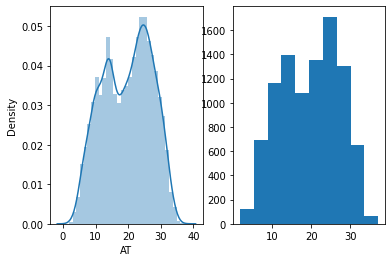

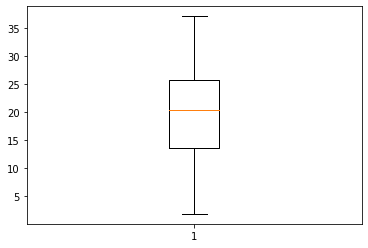

Số lượng outliers:  0
Tỉ lệ outliers so với mẫu 0.0



V
1\ Describe: 
 count    9527.000000
mean       54.293421
std        12.686309
min        25.360000
25%        41.740000
50%        52.080000
75%        66.510000
max        81.560000
Name: V, dtype: float64 

2\ Meadian:  52.08
3\ Mode:  <bound method Series.mode of 0       60.29
1       42.49
2       66.56
3       41.67
4       74.78
        ...  
9522    75.23
9523    62.96
9524    79.05
9525    58.20
9526    40.10
Name: V, Length: 9527, dtype: float64>
4\ Range:  56.2
5\ Variance:  160.9424362813333
6\ Số NaN:  0
7\ 	Q1 =  41.74
   	Q3 =  66.51
   	IQR =  24.770000000000003
8\ Skew:  0.1968187812768347
Phân phối lệch phải
9\ Kurtosis:  -1.4437579540469005
Phân phối bẹt hơn pp chuẩn


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


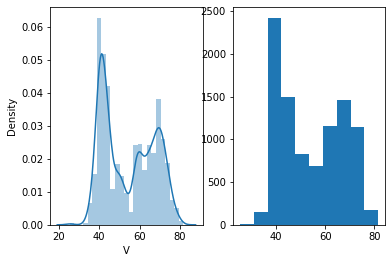

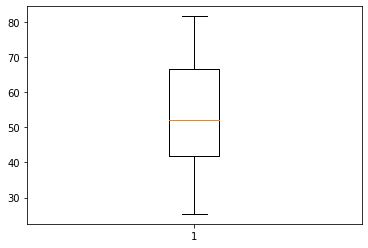

Số lượng outliers:  0
Tỉ lệ outliers so với mẫu 0.0



AP
1\ Describe: 
 count    9527.000000
mean     1013.237084
std         5.940526
min       992.890000
25%      1009.085000
50%      1012.920000
75%      1017.200000
max      1033.300000
Name: AP, dtype: float64 

2\ Meadian:  1012.92
3\ Mode:  <bound method Series.mode of 0       1017.42
1       1009.59
2       1005.31
3       1012.60
4       1010.05
         ...   
9522    1010.15
9523    1019.70
9524    1008.99
9525    1017.56
9526    1015.56
Name: AP, Length: 9527, dtype: float64>
4\ Range:  40.40999999999997
5\ Variance:  35.28984992606086
6\ Số NaN:  0
7\ 	Q1 =  1009.085
   	Q3 =  1017.2
   	IQR =  8.115000000000009
8\ Skew:  0.273845628693525
Phân phối lệch phải
9\ Kurtosis:  0.10417043779474389
Phân phối nhọn hơn pp chuẩn


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


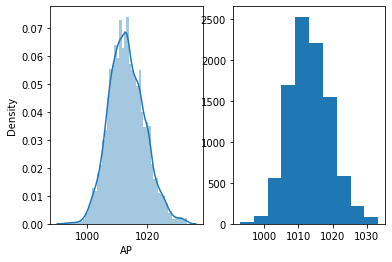

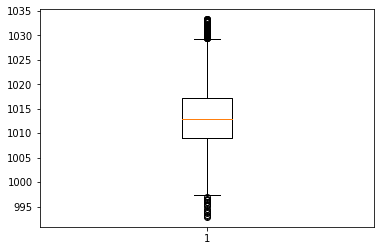

Số lượng outliers:  91
Tỉ lệ outliers so với mẫu 0.009551800146950772



RH
1\ Describe: 
 count    9527.000000
mean       73.334951
std        14.607513
min        25.560000
25%        63.375000
50%        75.000000
75%        84.850000
max       100.160000
Name: RH, dtype: float64 

2\ Meadian:  75.0
3\ Mode:  <bound method Series.mode of 0       58.94
1       77.36
2       71.97
3       49.27
4       60.82
        ...  
9522    54.87
9523    61.44
9524    94.32
9525    74.31
9526    82.44
Name: RH, Length: 9527, dtype: float64>
4\ Range:  74.6
5\ Variance:  213.37944343400187
6\ Số NaN:  0
7\ 	Q1 =  63.375
   	Q3 =  84.85
   	IQR =  21.474999999999994
8\ Skew:  -0.43513848893895296
Phân phối lệch trái
9\ Kurtosis:  -0.44051452963301996
Phân phối bẹt hơn pp chuẩn


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


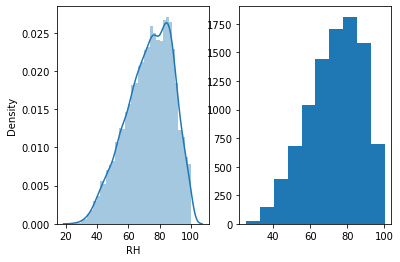

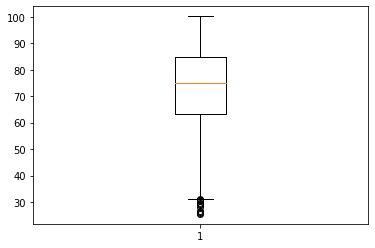

Số lượng outliers:  13
Tỉ lệ outliers so với mẫu 0.0013645428781358245



PE
1\ Describe: 
 count    9527.00000
mean      454.33591
std        17.03908
min       420.26000
25%       439.75000
50%       451.52000
75%       468.36500
max       495.76000
Name: PE, dtype: float64 

2\ Meadian:  451.52
3\ Mode:  <bound method Series.mode of 0       447.67
1       477.49
2       430.21
3       459.81
4       436.87
         ...  
9522    434.82
9523    446.09
9524    434.01
9525    448.92
9526    467.32
Name: PE, Length: 9527, dtype: float64>
4\ Range:  75.5
5\ Variance:  290.33026131576895
6\ Số NaN:  0
7\ 	Q1 =  439.75
   	Q3 =  468.365
   	IQR =  28.61500000000001
8\ Skew:  0.3057905126118896
Phân phối lệch phải
9\ Kurtosis:  -1.045391514470105
Phân phối bẹt hơn pp chuẩn


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


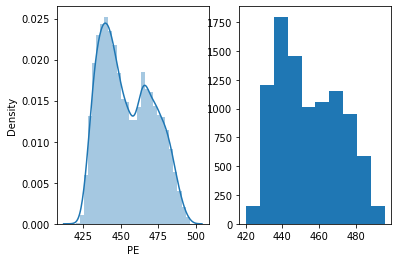

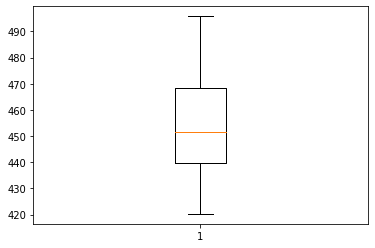

Số lượng outliers:  0
Tỉ lệ outliers so với mẫu 0.0





In [ ]:
df_continuous = df_pd[['AT', 'V', 'AP', 'RH', 'PE']]
for i in df_continuous:
    print(i)
    continuous_univariate_analysis(df_pd[i])
    visualize_histogram(df_pd[i])
    visualize_boxplot(df_pd[i])
    find_outliers(df_pd[i])
    print("\n====================================================\n\n")

In [ ]:
'''
ta thấy std của các thuộc tính khá nhỏ.
AP, RH có outliers, tuy nhiên đây là các outlier hợp lệ (do đặc trưng của dữ liệu)
'''

'\nta thấy std của các thuộc tính khá nhỏ.\nAP, RH có outliers, tuy nhiên đây là các outlier hợp lệ (do đặc trưng của dữ liệu)\n'

### **Phân tích đa biến**

In [ ]:
df_corr = df_continuous.corr()
df_corr

,AT,V,AP,RH,PE
AT,1.000000,0.843689,-0.508222,-0.543947,-0.947908
V,0.843689,1.000000,-0.415718,-0.312214,-0.869900
AP,-0.508222,-0.415718,1.000000,0.101631,0.518687
RH,-0.543947,-0.312214,0.101631,1.000000,0.391175
PE,-0.947908,-0.869900,0.518687,0.391175,1.000000


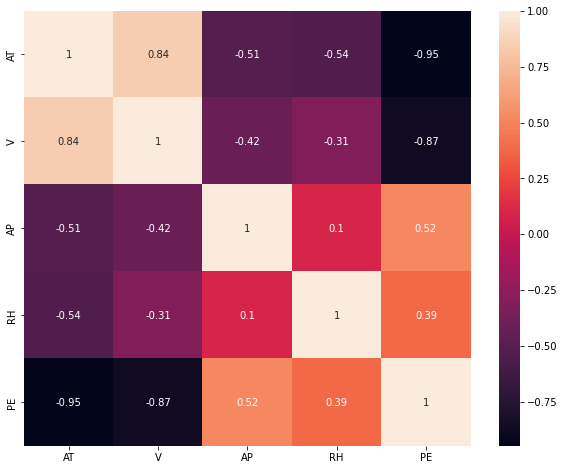

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_corr, annot=True)
plt.show()

'''
dựa vào số liệu và biểu đồ, ta thấy PE tương quan với tất cả các biến còn lại, trong đó tương quan mạnh với AT, V.

'''

### **Feature Transformations**

In [ ]:
df.columns

['AT', 'V', 'AP', 'RH', 'PE']

In [ ]:
assembler = VectorAssembler(inputCols=['AT', 'V', 'AP', 'RH'], outputCol='features')
data_pre = assembler.transform(df)

In [ ]:
data_pre.show(5)

+-----+-----+-------+-----+------+--------------------+
|   AT|    V|     AP|   RH|    PE|            features|
+-----+-----+-------+-----+------+--------------------+
|24.54|60.29|1017.42|58.94|447.67|[24.54,60.29,1017...|
|10.59|42.49|1009.59|77.36|477.49|[10.59,42.49,1009...|
| 26.7|66.56|1005.31|71.97|430.21|[26.7,66.56,1005....|
|21.24|41.67| 1012.6|49.27|459.81|[21.24,41.67,1012...|
|27.74|74.78|1010.05|60.82|436.87|[27.74,74.78,1010...|
+-----+-----+-------+-----+------+--------------------+
only showing top 5 rows



In [ ]:
final_data = data_pre.select("features",'PE')

### **Chuẩn bị dữ liệu train - test**

In [ ]:
train_data,test_data = final_data.randomSplit([0.7,0.3])

In [ ]:
train_data.describe().show()


+-------+------------------+
|summary|                PE|
+-------+------------------+
|  count|              6575|
|   mean|454.44748593155896|
| stddev|17.101963746030986|
|    min|            420.26|
|    max|            495.76|
+-------+------------------+



In [ ]:
test_data.describe().show()


+-------+------------------+
|summary|                PE|
+-------+------------------+
|  count|              2952|
|   mean| 454.0873949864497|
| stddev|16.898415017816017|
|    min|            421.57|
|    max|            495.24|
+-------+------------------+



In [ ]:
'''
Các thông số như mean, std, max, min của train_dataset và test_dataset khá tương đồng với nhau
'''

'\nCác thông số như mean, std, max, min của train_dataset và test_dataset khá tương đồng với nhau\n'

### **Xây dựng model**
Chúng ta chọn một vài thuật toán classification:
- Linear Regression
- Decision Tree
- Random Forest

In [ ]:
def regression_evalution(model_fixed, training, testing):
    test_results = model_fixed.evaluate(test_data)
    test_results.residuals.show(5)

    print("R-Square: {}".format(test_results.r2))
    print("RMSE: {}".format(test_results.rootMeanSquaredError))
    print("MSE: {}".format(test_results.meanSquaredError))
    print("MAE: {}".format(test_results.meanAbsoluteError))

    print('\n prediction tabel')
    test_model = model_fixed.transform(testing)
    test_model.show(10)

    df_visualization = test_model.select(model_fixed.getLabelCol(), model_fixed.getPredictionCol()).toPandas()
    col = df_visualization.columns
    plt.figure(figsize=(6, 6))
    plt.scatter(df_visualization[col[0]], df_visualization[col[1]])
    plt.plot([400, 550], [400, 550], "r-")
    plt.xlabel("Model predictions")
    plt.ylabel("True value")
    plt.show()


In [ ]:
# dành cho các thuật toán ko hỗ trợ model_fixed.evalute (vd randomforest, gbt, ...)
def regression_evalution_grumpy(model_fixed, training, testing):
    predictions = model_fixed.transform(test_data)
    print('\n prediction tabel')
    predictions.show(10)
    r2 = RegressionEvaluator(labelCol='PE', predictionCol='prediction', metricName='r2').evaluate(predictions)
    RMSE = RegressionEvaluator(labelCol='PE', predictionCol='prediction', metricName='rmse').evaluate(predictions)
    MSE = RegressionEvaluator(labelCol='PE', predictionCol='prediction', metricName='mse').evaluate(predictions)
    MAE = RegressionEvaluator(labelCol='PE', predictionCol='prediction', metricName='mae').evaluate(predictions)

    print('R-Squre', r2)
    print('RMSE', RMSE)
    print('MSE', MSE)
    print('MAE', MAE)

    df_visualization = predictions.select(model_fixed.getLabelCol(), model_fixed.getPredictionCol()).toPandas()
    col = df_visualization.columns
    plt.figure(figsize=(6, 6))
    plt.scatter(df_visualization[col[0]], df_visualization[col[1]])
    plt.plot([400, 550], [400, 550], "r-")
    plt.xlabel("Model predictions")
    plt.ylabel("True value")
    plt.show()


### **Build model với Linear Regression**

In [ ]:
start_time_lr = datetime.datetime.now()

lr = LinearRegression(featuresCol="features", labelCol='PE')
lrModel = lr.fit(train_data)

end_time_lr = datetime.datetime.now()

In [ ]:
runtime_lr = end_time_lr - start_time_lr
runtime_lr.total_seconds()

9.52086

+-------------------+
|          residuals|
+-------------------+
|  6.739358571568232|
|0.13131623214684396|
|  7.132148850529802|
|-2.2638726284064887|
|-4.3456587474190655|
+-------------------+
only showing top 5 rows

R-Square: 0.9260142379485952
RMSE: 4.595645026606914
MSE: 21.119953210576863
MAE: 3.6294533731377117

 prediction tabel
+--------------------+------+------------------+
|            features|    PE|        prediction|
+--------------------+------+------------------+
|[8.48,42.49,1010....| 483.5|476.76064142843177|
|[9.08,36.71,1025....|479.02|478.88868376785314|
|[10.67,40.56,1022...|482.36| 475.2278511494702|
|[14.09,44.47,1029...|466.53|468.79387262840646|
|[15.37,43.34,1014...|460.02|464.36565874741905|
|[15.73,38.73,1002...|466.63|464.51124536366046|
|[16.53,46.18,1010...|458.67| 458.7197995707729|
|[17.66,60.08,1017...|456.62| 455.0943635952709|
|[22.55,70.79,1006...|436.43|441.35279432627203|
|[24.79,50.78,1008...| 445.3| 446.4592391157178|
+-------------------

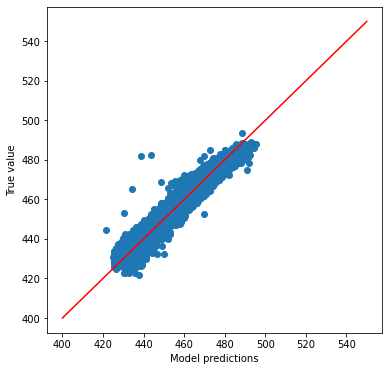

In [ ]:
regression_evalution(lrModel, train_data, test_data)

In [ ]:
'''
R-square cao, RMSE và MSE, MAE đều thấp => thích hợp để sử dụng
'''

'\nR-square cao, RMSE và MSE đều thấp => thích hợp để sử dụng\n'

### **Build model với DecisonTree**

In [ ]:
start_time_dt = datetime.datetime.now()

dt = DecisionTreeRegressor(featuresCol="features", labelCol='PE')
dtModel = lr.fit(train_data)

end_time_dt = datetime.datetime.now()

In [ ]:
runtime_dt = end_time_dt - start_time_dt
runtime_dt.total_seconds()

6.662644

+------------------+
|         residuals|
+------------------+
| 6.739358571587559|
|0.1313162321275172|
| 7.132148850516728|
|-2.263872628441163|
|-4.345658747420032|
+------------------+
only showing top 5 rows

R-Square: 0.9260142379485973
RMSE: 4.595645026606849
MSE: 21.119953210576266
MAE: 3.6294533731381797

 prediction tabel
+--------------------+------+------------------+
|            features|    PE|        prediction|
+--------------------+------+------------------+
|[8.48,42.49,1010....| 483.5|476.76064142841244|
|[9.08,36.71,1025....|479.02|478.88868376787246|
|[10.67,40.56,1022...|482.36| 475.2278511494833|
|[14.09,44.47,1029...|466.53|468.79387262844114|
|[15.37,43.34,1014...|460.02|   464.36565874742|
|[15.73,38.73,1002...|466.63| 464.5112453636287|
|[16.53,46.18,1010...|458.67|  458.719799570767|
|[17.66,60.08,1017...|456.62|455.09436359528075|
|[22.55,70.79,1006...|436.43|441.35279432626004|
|[24.79,50.78,1008...| 445.3|446.45923911571197|
+--------------------+------+

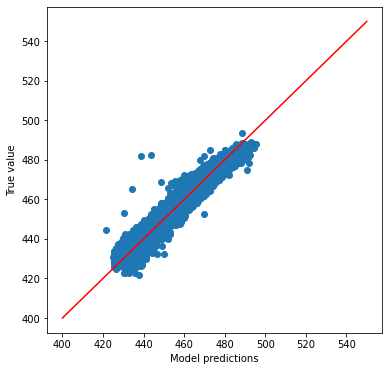

In [ ]:
regression_evalution(dtModel, train_data, test_data)

In [ ]:
'''
R-square cao, RMSE và MSE, MAE đều thấp => thích hợp để sử dụng
'''

'\nR-square cao, RMSE và MSE, MAE đều thấp => thích hợp để sử dụng\n'

### **Build model với RandomForest**

In [ ]:
start_time_rd = datetime.datetime.now()

rd = RandomForestRegressor(featuresCol="features", labelCol='PE')
rdModel = rd.fit(train_data)

end_time_rd = datetime.datetime.now()

In [ ]:
runtime_rd = end_time_rd - start_time_rd
runtime_rd.total_seconds()

46.801032


 prediction tabel
+--------------------+------+------------------+
|            features|    PE|        prediction|
+--------------------+------+------------------+
|[8.48,42.49,1010....| 483.5| 480.5053005031856|
|[9.08,36.71,1025....|479.02| 478.1093156385784|
|[10.67,40.56,1022...|482.36| 477.6777759173472|
|[14.09,44.47,1029...|466.53|467.22876877903656|
|[15.37,43.34,1014...|460.02| 466.6551634693228|
|[15.73,38.73,1002...|466.63| 464.3163887170316|
|[16.53,46.18,1010...|458.67|456.18024116820544|
|[17.66,60.08,1017...|456.62| 451.5967382555833|
|[22.55,70.79,1006...|436.43| 440.5552239589518|
|[24.79,50.78,1008...| 445.3| 442.8417425225475|
+--------------------+------+------------------+
only showing top 10 rows

R-Squre 0.934891463221795
RMSE 4.311132470096477
MSE 18.585863174720153
MAE 3.2769738089984615


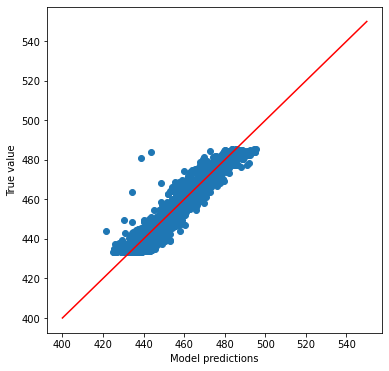

In [ ]:
regression_evalution_grumpy(rdModel, train_data, test_data)

In [ ]:
'''
R-square cao, RMSE và MSE, MAE đều thấp => thích hợp để sử dụng
'''

'\nR-square cao, RMSE và MSE, MAE đều thấp => thích hợp để sử dụng\n'

### **Build model với GBTRegressor**

In [ ]:
start_time_gbt = datetime.datetime.now()

gbt = GBTRegressor(featuresCol="features", labelCol='PE')
gbtModel = gbt.fit(train_data)

end_time_gbt = datetime.datetime.now()

In [ ]:
runtime_gbt = end_time_gbt - start_time_gbt
runtime_gbt.total_seconds()

154.267517


 prediction tabel
+--------------------+------+------------------+
|            features|    PE|        prediction|
+--------------------+------+------------------+
|[8.48,42.49,1010....| 483.5| 480.2687676552236|
|[9.08,36.71,1025....|479.02|477.87072668297355|
|[10.67,40.56,1022...|482.36|477.66018027769036|
|[14.09,44.47,1029...|466.53| 467.7128638742364|
|[15.37,43.34,1014...|460.02| 466.2185079175187|
|[15.73,38.73,1002...|466.63|463.54360241597794|
|[16.53,46.18,1010...|458.67|458.80766156881265|
|[17.66,60.08,1017...|456.62| 451.7839513636176|
|[22.55,70.79,1006...|436.43|  439.629070413068|
|[24.79,50.78,1008...| 445.3| 444.6424798332992|
+--------------------+------+------------------+
only showing top 10 rows

R-Squre 0.9425141309043394
RMSE 4.050913325219812
MSE 16.40989876844344
MAE 3.0303652715844493


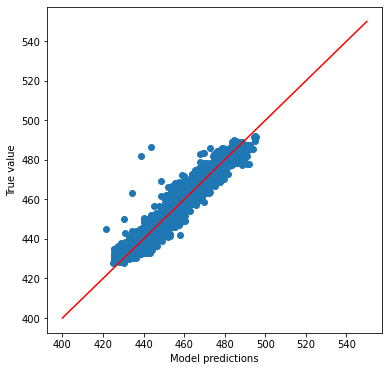

In [ ]:
regression_evalution_grumpy(gbtModel, train_data, test_data)

In [ ]:
'''
R-square cao, RMSE và MSE, MAE đều thấp => thích hợp để sử dụng
'''

'\nR-square cao, RMSE và MSE, MAE đều thấp => thích hợp để sử dụng\n'

## **Đánh Giá**


Nhìn chung, các thuật toán đều cho ra kết quả tốt: r-square cao, MAE - MSE - RMSE nhỏ.
Ở đây em chọn GBTRegressor vì nó cho score cao nhất ~ 0.9425 và 
các chỉ số MAE, MSE, RMSE thấp nhất (RMSE ~ 4; MSE ~ 16 MAE ~ 3) mặc dù thời gian train là lâu nhất.
Ngoài ra, có thể kết hợp hyper parameters và boosting để tăng cường cho model (tuy nhiên vì thời gian và tài nguyên có hạn nên em tạm chấp nhận thang điểm trên)

Nếu muốn tiết kiệm thời gian, chúng ta có thể chon decision tree vì thời gian fit của nó là nhanh nhất (chỉ 6.6s)


### **Lưu model**

In [ ]:
gbtModel.save('Exercise3/ex3_GBTRegressor_model')

In [ ]:
gbt = GBTRegressionModel.load("Exercise3/ex3_GBTRegressor_model")